# Days Per Year

## Setup and connect to database

In [1]:
import psycopg2
import ipywidgets as widgets
from shapely import wkb
import geopandas as gpd
from matplotlib import pyplot as plt

DB_HOST = 'localhost'
DB_USER = 'postgres'
DB_PASSWORD = 'postgres'
DB_NAME = 'socat_kpi'

conn = psycopg2.connect(database = DB_NAME, 
                        user = DB_USER, 
                        host= DB_HOST,
                        password = DB_PASSWORD)

cur = conn.cursor()


## Select Region
Count how many SOCAT points fall in a selected region.

In [2]:
menu_options = []

cur.execute("SELECT id, source, name FROM regions ORDER BY source, name")
for record in cur:
    menu_options.append((f'{record[1]}: {record[2]}', record[0]))

region = widgets.Dropdown(
    options=menu_options,
    description='Region:',
)
display(region)

Dropdown(description='Region:', options=(('CCAMLR: Division 58.4.1', 19), ('CCAMLR: Division 58.4.2', 20), ('C…

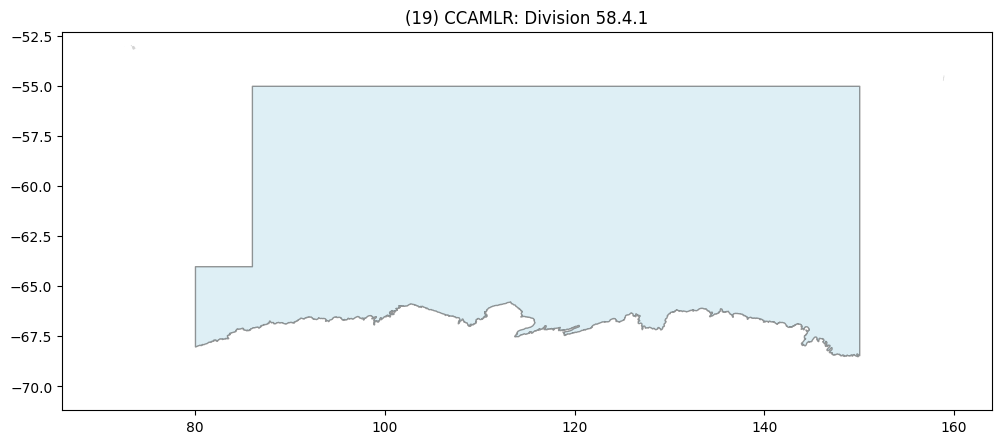

In [3]:
cur.execute(f'SELECT shape FROM regions WHERE id = {region.value}')
geom = wkb.loads(cur.fetchone()[0], hex=False)
gdf = gpd.GeoDataFrame([{'id': region.value, 'geometry': geom}], geometry='geometry', crs='EPSG:4326')
coastlines = gpd.read_file('shapes/coastline/GSHHS_i_L1.shp')

minx, miny, maxx, maxy = gdf.total_bounds
padding_x = (maxx - minx) * 0.2  # 20% padding
padding_y = (maxy - miny) * 0.2

xlim = (minx - padding_x, maxx + padding_x)
ylim = (miny - padding_y, maxy + padding_y)


fig, ax = plt.subplots(figsize=(12, 6))
coastlines.plot(ax=ax, color='lightgray', linewidth=0.5)
gdf.plot(ax=ax, color='lightblue', alpha=0.4, edgecolor='black')  # your polygon from PostGIS
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.title(f"({region.value}) {region.label}")
plt.show()

## Get the number of days per year with observations

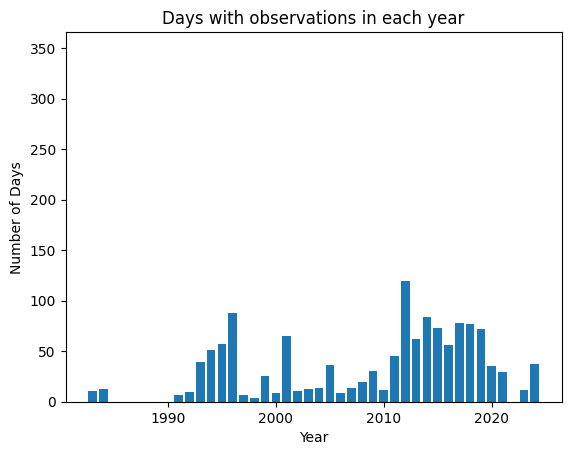

In [4]:
cur.execute(f"SELECT s.year, COUNT(DISTINCT(s.month_day)) FROM socat s INNER JOIN regions r ON s.position && r.shape AND ST_Intersects(s.position, r.shape) WHERE r.id = {region.value} GROUP BY s.year ORDER BY s.year")

years = []
counts = []

for record in cur:
    years.append(record[0])
    counts.append(record[1])

plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.ylim((0, 366))
plt.title('Days with observations in each year')
plt.show()

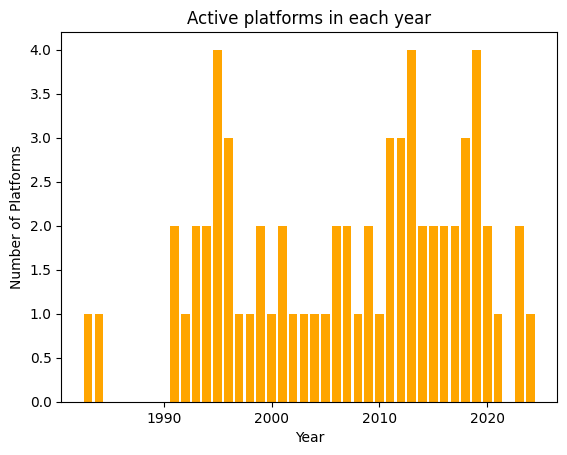

In [5]:
cur.execute(f"SELECT s.year, COUNT(DISTINCT(s.platform_code)) FROM socat s INNER JOIN regions r ON s.position && r.shape AND ST_Intersects(s.position, r.shape) WHERE r.id = {region.value} GROUP BY s.year ORDER BY s.year")

years = []
counts = []

for record in cur:
    years.append(record[0])
    counts.append(record[1])

plt.bar(years, counts, color='orange')
plt.xlabel('Year')
plt.ylabel('Number of Platforms')
plt.title('Active platforms in each year')
plt.show()

## Shutdown

In [23]:
cur.close()
conn.close()